In [11]:
#Python Packages
import numpy as np #Used to for statistical and algebraic calculations
import pandas as pd #Used for Data Processing
from scipy.stats import *   #Common Dist
import matplotlib.pyplot as plt #Used for graphing

## Data Processing

Below is where we perform data processing, in essence turning the imported data into more manageable forms. The main processing completed was determining the counts for both UFO sightings and military bases for each state since the data provided raw data for each sighting/base. Further data cleaning was performed to rename column names, omit unwanted years, and standardize the UFO sightings per square mile, to account for the increased size of the state. We standardized to the state area instead of the state population because the population is variable and dependent on the year, while the square milage and number of military bases are roughly stagnant in the 21st century.

In [57]:
#Turn csv files into Dataframes
ufo_df = pd.read_csv("scrubbed.csv", low_memory=False)
mil_df = pd.read_csv("military-bases.csv", low_memory=False)
sizes_df = pd.read_csv("state-areas.csv")

#Used to modify ufo dataframe to have full state names
state_mapping = {
    'al': 'Alabama', 'ak': 'Alaska', 'az': 'Arizona', 'ar': 'Arkansas', 'ca': 'California',
    'co': 'Colorado', 'ct': 'Connecticut', 'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
    'hi': 'Hawaii', 'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana', 'ia': 'Iowa', 'ks': 'Kansas',
    'ky': 'Kentucky', 'la': 'Louisiana', 'me': 'Maine', 'md': 'Maryland', 'ma': 'Massachusetts',
    'mi': 'Michigan', 'mn': 'Minnesota', 'ms': 'Mississippi', 'mo': 'Missouri', 'mt': 'Montana',
    'ne': 'Nebraska', 'nv': 'Nevada', 'nh': 'New Hampshire', 'nj': 'New Jersey', 'nm': 'New Mexico',
    'ny': 'New York', 'nc': 'North Carolina', 'nd': 'North Dakota', 'oh': 'Ohio', 'ok': 'Oklahoma',
    'or': 'Oregon', 'pa': 'Pennsylvania', 'ri': 'Rhode Island', 'sc': 'South Carolina', 'sd': 'South Dakota',
    'tn': 'Tennessee', 'tx': 'Texas', 'ut': 'Utah', 'vt': 'Vermont', 'va': 'Virginia',
    'wa': 'Washington', 'wv': 'West Virginia', 'wi': 'Wisconsin', 'wy': 'Wyoming'
}

#UFO data processing
ufo_df['datetime'] = ufo_df['datetime'].str.replace('24:00', '00:00') #Processing to acquire a year variable
ufo_df['datetime'] = pd.to_datetime(ufo_df['datetime'], format='%m/%d/%Y %H:%M')
ufo_df['year'] = ufo_df['datetime'].dt.year
ufo_df = ufo_df[ufo_df['year'] >=2000] #Change to only "modern" age, to align with stagnant military base number
ufo_df = ufo_df[ufo_df['state']!='pr'] #Removed Puerto Rico
ufo_df = ufo_df[ufo_df['state']!='dc'] #Removed DC
ufo_df = ufo_df[ufo_df['country']=='us'] #Remove all non-US areas
ufo_df['state'] = ufo_df['state'].map(state_mapping) #Rename state variables

#Military Base data processing
mil_df = mil_df[mil_df['State Terr'] != "Guam"] #Remove Guam
mil_df = mil_df[mil_df['State Terr'] != "District of Columbia"] #Remove DC
mil_df = mil_df[mil_df['State Terr'] != "Puerto Rico"] #Remove Puerto Rico

#Sizes data processing
sizes_df = sizes_df[sizes_df['state'] !="District of Columbia"] #Remove DC
sizes_df = sizes_df[sizes_df['state'] !="Puerto Rico"] #Remove Puerto Rico

#Provides Counts for each State
ufoPerState = ufo_df['state'].value_counts()
milPerState = mil_df['State Terr'].value_counts()

#Conversion to Dataframe
ufoPerState_df = ufoPerState.rename('UFOCount').reset_index()
milPerState_df = milPerState.rename('MilitaryBaseCount').reset_index()

data = pd.merge(ufoPerState_df,milPerState_df,on="index",how="outer") #First Merge

data = data.rename(columns={'index': 'State'}) #Renaming State Column
sizes_df = sizes_df.rename(columns={'state': 'State'})

data = pd.merge(data,sizes_df,on="State",how="outer") #Second Merge

data['UFOCountPerSqMi'] = data['UFOCount']/data['area (sq. mi)'] #Creates a per area variable for proper comparisons

data.head()

,State,UFOCount,MilitaryBaseCount,area (sq. mi),UFOCountPerSqMi
0,California,7285,73,163707,0.044500
1,Florida,3296,41,65758,0.050123
2,Washington,3102,20,71303,0.043504
3,Texas,2755,42,268601,0.010257
4,New York,2319,17,54475,0.042570


### Variable Creation

In [4]:
ufo = data['UFOCountPerSqMi']
mil = data['MilitaryBaseCount']

## Distribution

### Density Histogram vs. Theoretical Normal Distribution

The following code re-plots the Military base data, but now as a density function. It also plots a theoretical normal distribution onto the same plot for comparative analysis. These steps are completed mainly with Matplotlib.

Text(0.5, 1.0, 'Military Base Density histogram vs Predicted Normal Distribution')

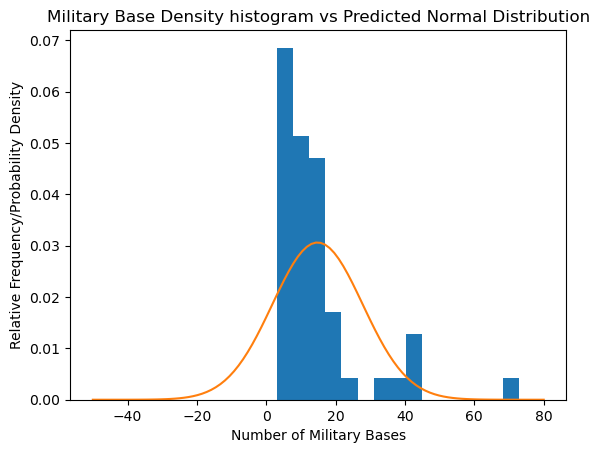

In [39]:
mil_mean = mil.mean()
mil_sd = mil.std(ddof=1)

x=np.linspace(-50,80,100)
plt.hist(mil, bins=15, density=True)
plt.plot(x,norm.pdf(x,loc=mil_mean,scale=mil_sd))

plt.xlabel('Number of Military Bases')
plt.ylabel('Relative Frequency/Probability Density')
plt.title('Military Base Density histogram vs Predicted Normal Distribution')

### Q-Q plot

The following cell plots our Military base data onto a Q-Q plot. First we sorted the data, and then created the theoretical quantiles of this data, based on a normal distribution. Next, we plotted these theoretical quantiles versus our sorted data. For comparative analysis, we also plotted the baseline for a perfect normal distribution, as represented by the red line.

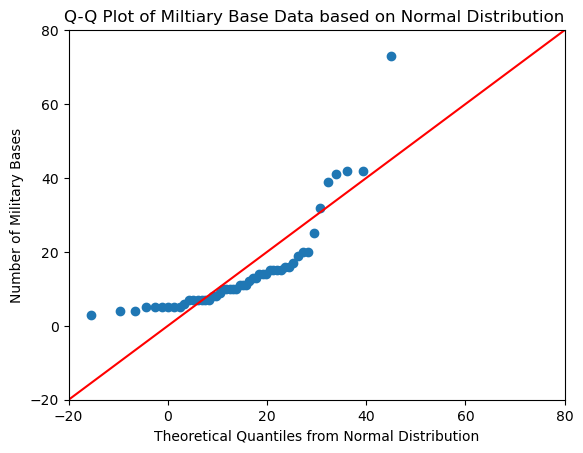

In [60]:
mil_sorted = np.sort(mil) #Sorting for quantile organization
sample_size = len(mil) #Sample size

q = np.linspace((1-0.5)*(1/sample_size), (sample_size-0.5)*(1/sample_size), sample_size) #Quantiles
theoretical_quantiles = norm.ppf(q, loc=mil_mean, scale=mil_sd) #Mapping to norm
plt.scatter(theoretical_quantiles, mil_sorted) #Graphing quantiles and sorted military data
plt.axline([0, 0], [1, 1] , c='r') #Baseline Norm

#Graph Labeling and Sizing
plt.xlabel('Theoretical Quantiles from Normal Distribution')
plt.ylabel('Number of Military Bases')
plt.title('Q-Q Plot of Miltiary Base Data based on Normal Distribution ')
plt.xlim(-20,80)
plt.ylim(-20,80)

plt.show()

### Comparison to Normal Distribution

Above we have plotted both a graph comparing the military base data to a theoretical normal distribution, as well as a Q-Q plot comparing the quantiles of our military base data to the quantiles of the theoretical normal distribution. From both, it is evident that the military base data is likely not normal, since it neither aligns in the histogram comparison nor the Q-Q plot comparison. In the histogram, the major right-skewness of the data differs from the symmetrical normal distribution. Furthermore, the lack of fit to a linear baseline in the Q-Q plot indicates that a normal distribution is not the correct fitting.